In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import io
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import glob
import random

from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import scipy.integrate as integrate
import lightkurve

from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

import math
import datetime as dt
import lightkurve.io as l
from lightkurve.io.generic import read_generic_lightcurve

In [2]:
LP261 = io.readsav('C:/Users/kmanj/Manjavacas Research/Manjavacas_Spectra/LP261_speccube_1.sav')
cant_spectra = 66

#obtain time
fecha_mjd  = LP261['time'][0]
fecha  = Time(fecha_mjd, format='mjd')
fechas  = fecha .datetime

time  = []
for i in range(0,cant_spectra):
    times = fechas [i]-fechas [0]
    time.append(round(times.total_seconds()/3600, 5))

In [3]:
files_fit = []
for i in range(0,66):
    files_fit.append(fits.open("{}{}{}".format('C:/Users/kmanj/Manjavacas Research/Manjavacas_Spectra/LP261/spectra_LP261_7fwhm_', i, '.fits')))

In [4]:
# separate the columns data
lambda_= []
flux = []
eflux = []
for i in range(0,cant_spectra):
    lambda_.append(files_fit[i][0].data[:,0])
    flux.append(files_fit[i][0].data[:,3])
    eflux.append(files_fit[i][0].data[:,4])

In [5]:
# generate light curve
total_flux = []
error_total_flux = []

for i in range(0,cant_spectra):
    total_flux.append(integrate.simps(flux[i],lambda_[0])/(lambda_[i][len(lambda_[0])-1]-lambda_[i][0]))
    error_total_flux.append(integrate.simps(eflux[i],lambda_[i])/((lambda_[i][len(lambda_[0])-1]-lambda_[i][0])*np.sqrt(len(eflux[i]))))

In [6]:
# Normalisation factor
cv_temp  = np.median(total_flux)
ecv_temp  = np.median(error_total_flux)**2/np.sqrt(cant_spectra)

In [7]:
# Normalised light curve
normal_flux = total_flux/cv_temp
enormal_flux = []
for i in range(0,cant_spectra):
    enormal_flux.append(normal_flux[i]*np.sqrt((error_total_flux[i]/total_flux[i])**2 + (ecv_temp/cv_temp)**2))

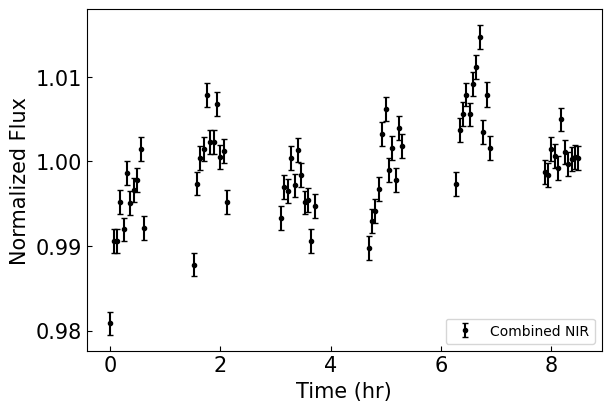

In [8]:
fig = plt.figure(figsize=(6, 4), constrained_layout = True)

plt.rcParams['font.family'] = "DejaVu Sans" # Tipo de letra general
plt.rcParams['font.size'] = 15 # Tamaño de letra general
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

(_, caps, _) = plt.errorbar(time, normal_flux,yerr=enormal_flux,capsize=2, marker ='.',ls='',color='black',label ='Combined NIR')

for cap in caps:
    cap.set_markeredgewidth(1)
plt.legend(loc='lower right', ncol=2, fancybox=True, shadow=False,frameon=True, fontsize=10)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (hr)')
#plt.title('LP261-75B')
plt.tick_params('x', labelbottom=True)

#fig.savefig('LC_lp261.pdf', bbox_inches='tight')

plt.show()

In [9]:
Reference = 'Manjavacas et al 2018 AJ 155 11'
Telescope = 'Hubble Space Telescope'
Object = 'LP261-75B'
SpectralType = 'L6'
Jmag = '17.29 +/- 0.25'
Hmag = '15.77 +/- 0.14'
Kmag = '15.04 +/- 0.12'
RA = 147.7722925
DEC = 35.96649102
Instrument = 'HST/WFC3'
filter1 = 'G141 grism'
Date_obs = 'December 21st, 2016'
Band_obs = '1.1 - 1.69 microns'
TSTART = 57742.58988125
TSTOP = 57742.6176753472

In [10]:
new_format = pd.DataFrame()

new_format['Time'] = time
new_format['Flux'] = normal_flux
new_format['eFlux'] = enormal_flux

In [11]:
lc = l.LightCurve(time = list(time) * u.h, flux = list(normal_flux) * u.dimensionless_unscaled, flux_err = list(enormal_flux) * u.dimensionless_unscaled)
lc

time,flux,flux_err
,,
Time,float64,float64
0.0,0.9808689405874663,0.0013908250846904808
0.00254625,0.9905949036358963,0.0014010208885332886
0.0050925,0.9905966403365557,0.0014024621190724884
0.00763875,0.9952194203537826,0.0014095791368143702
0.010185,0.9919636088617644,0.0013986424865850295
0.012731666666666667,0.9986017171972534,0.0014053373762746336
0.015277916666666667,0.9951314865947565,0.001407374628460814
0.017824166666666665,0.9966447619495119,0.0014194844031082102


In [12]:
dir_save = "C:/Users/kmanj/FITS_BD_Files/Data/Manjavacas_2018/"

In [13]:
lc.to_fits(path = dir_save + 'LP261-75B_Manj2018.fits')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001A62A09B250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001A63341BFD0>]

In [14]:
with fits.open(dir_save + 'LP261-75B_Manj2018.fits', mode = 'update') as f:
    f[0].header['OBJECT'] = Object
    f[0].header['SPECTYPE'] = SpectralType
    f[0].header['DATE_OBS'] = Date_obs
    f[0].header['SPECBAND'] = Band_obs
    f[0].header['TSTART'] = TSTART
    f[0].header['TSTOP'] = TSTOP
    f[0].header['TIMESYS'] = 'mjd'
    f[0].header['TELESCOP'] = Telescope
    f[0].header['INSTRUME'] = Instrument
    f[0].header['FILTER'] = filter1
    f[0].header['VOREF'] = Reference
    f[0].header['RA_OBJ'] = RA
    f[0].header['DEC_OBJ'] = DEC
    f[0].header['JMAG'] = Jmag
    f[0].header['HMAG'] = Hmag
    f[0].header['KMAG'] = Kmag

<Axes: xlabel='Time', ylabel='Flux'>

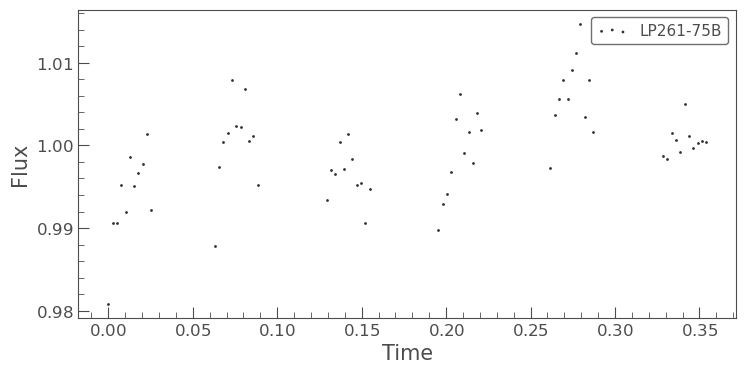

In [15]:
bc = read_generic_lightcurve(dir_save + 'LP261-75B_Manj2018.fits', time_format = 'mjd')
bc.scatter()